# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 0. Загрузка данных

In [1]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import os
import random
import re
import requests
import spacy
import torch
#import torch.nn as nn
import torchvision.models as models
from PIL import Image
#from scipy.spatial import distance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import ElasticNet
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
import catboost
from pathlib import Path

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
filename = "dsplus_integrated_project_4.zip"
url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

# Проверяем, существует ли файл в текущей директории. Если нет, то загружаем, если да, то ничего не делаем
if not os.path.exists(filename):
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"Файл {filename} успешно загружен.")
else:
    print(f"Файл {filename} уже существует в текущей директории. Загрузка не требуется.")

Файл dsplus_integrated_project_4.zip успешно загружен.


In [5]:
from zipfile import ZipFile
with ZipFile('dsplus_integrated_project_4.zip', 'r') as zf:
    zf.extractall('dsplus_4/')

In [6]:
pwd

'/content'

In [7]:

PATH = '/content/dsplus_4/to_upload'
#Путь к папке с тренировочными изображениями
PATH_TRAIN = "/content/dsplus_4/to_upload/train_images/"
#Путь к папке с тестовыми изображениями
PATH_TEST = "/content/dsplus_4/to_upload/test_images/"


In [8]:
'''
# загрузка файлов в каггл-сессию
PATH = '/kaggle/working/dsplus_4/to_upload'
#Путь к папке с тренировочными изображениями
PATH_TRAIN = "/kaggle/working/dsplus_4/to_upload/train_images/"
#Путь к папке с тестовыми изображениями
PATH_TEST = "/kaggle/working/dsplus_4/to_upload/test_images/"

'''

'\n# загрузка файлов в каггл-сессию\nPATH = \'/kaggle/working/dsplus_4/to_upload\'\n#Путь к папке с тренировочными изображениями\nPATH_TRAIN = "/kaggle/working/dsplus_4/to_upload/train_images/"\n#Путь к папке с тестовыми изображениями\nPATH_TEST = "/kaggle/working/dsplus_4/to_upload/test_images/"\n\n'

In [9]:
df_train = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))

In [10]:
df_train.sample(10)

,image,query_id,query_text
1536,1348304997_afe60a61df.jpg,241345811_46b5f157d4.jpg#2,A football player in red and white is talking ...
2703,498444334_a680d318a1.jpg,245895500_a4eb97af02.jpg#2,Man fly fishing in a small river with steam in...
5604,3053743109_a2d780c0d2.jpg,2575647360_f5de38c751.jpg#2,People gathered in an artist 's studio .
5501,2926595608_69b22be8d4.jpg,3053743109_a2d780c0d2.jpg#2,A group of basketball players jump in the air ...
5288,317109978_cb557802e1.jpg,2333288869_8c01e4c859.jpg#2,A woman and a naked child wade into the ocean .
2890,3245070961_8977fdd548.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
3471,3213992947_3f3f967a9f.jpg,1561658940_a947f2446a.jpg#2,A little girl sits in a plastic swing set .
4852,2443380641_7b38d18f5b.jpg,3585598356_8ce815bbb9.jpg#2,two woman are showing different facial express...
3954,540721368_12ac732c6c.jpg,170100272_d820db2199.jpg#2,A girl goes down a blue and yellow slide at a ...
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [12]:
df_train.duplicated().sum()

0

In [13]:
df_train.query("image == '132489044_3be606baf7.jpg'")

,image,query_id,query_text
45,132489044_3be606baf7.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...
61,132489044_3be606baf7.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...
830,132489044_3be606baf7.jpg,3591462960_86045906bd.jpg#2,A rodeo rider gets tossed up into the air by a...
1109,132489044_3be606baf7.jpg,3727752439_907795603b.jpg#2,a woman wearing a black and white outfit while...
1357,132489044_3be606baf7.jpg,3191135894_2b4bdabb6d.jpg#2,A smaller art festival on the edge of a forest
1360,132489044_3be606baf7.jpg,3416091866_a96003d652.jpg#2,A man in a striped shirt is demonstrating a pr...


Видим, что в тренировочном датасете 5822 строк, то есть на каждую из 1000 картинок приходится в среднем 5,8 описаний. И действительно, для изображения 132489044_3be606baf7.jpg нашлось 6 очень разных описаний.
      

In [14]:
df_train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


При этом уникальных запросов всего 977, даже меньше, чем изображений.

In [15]:
crowd_annotations = pd.read_csv(os.path.join(PATH,'CrowdAnnotations.tsv'),  sep='\t', header=None, names=['image', 'query_id', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'])
crowd_annotations.head(10)

,image,query_id,percentage_confirmed,quantity_confirmed,quantity_disproved
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


In [16]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 47830 non-null  object 
 1   query_id              47830 non-null  object 
 2   percentage_confirmed  47830 non-null  float64
 3   quantity_confirmed    47830 non-null  int64  
 4   quantity_disproved    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [17]:
crowd_annotations.duplicated().sum()

0

In [18]:
crowd_annotations.describe()

,percentage_confirmed,quantity_confirmed,quantity_disproved
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


В файле crowd_annotations пропусков тоже нет.

В среднем почти 7% из опрошенных подтверждают, что описание соответствует изображению. При этом, есть максимальное значение — 1, что означает, что есть изображения с описанием, релевантность которого  подвердили абсолютно все "краудсорсеры".

In [19]:
expert_annotations = pd.read_csv(os.path.join(PATH,'ExpertAnnotations.tsv'), sep='\t', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
expert_annotations.head(10)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


In [20]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [21]:
expert_annotations.duplicated().sum()

0

In [22]:
expert_annotations.describe()

,expert_1,expert_2,expert_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Ни пропусков, ни каких-то аномалий не наблюдается. Отметим, что третий эксперт оценивает сходство запроса и картинки выше коллег (среднее 1,88 против 1,4 и 1,6, и медиана 2 против единицы у первых двух экспертов)

In [23]:
test_queries = pd.read_csv(os.path.join(PATH,'test_queries.csv'), sep='|', index_col=0)
test_queries.head(10)

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


In [24]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [25]:
test_queries.duplicated().sum()

0

In [26]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Всё логично: 100 изображений, по 5 запросов на каждое.

**ВЫВОДЫ**

- Проведена загрузка данных, созданы переменные для них.
- Обнаружено, что в работе на краудсорсинге соответствие текстового запроса изображению отмечается менее, чем в 7% случаев.
- Эксперты в целом также невысоко оценивают соответствие текста изображению, их средние оценки колеблются в диапазоне 1,4-1,9 баллов из 4, а третий квартиль соответствует оценке 2, которая означает, что запрос и изображение непохожи.
- Экспертных оценок у нас 5822 запросов × 3 эксперта, а краудсорсинговых 47830, попробуем учесть эту разницу в дальнейшем.


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.




In [27]:
# Удалим пары «изображение-запрос», где от всех трёх экспертов получены разные оценки
unique_votes = expert_annotations.loc[:,['expert_1', 'expert_2', 'expert_3']].apply(pd.Series.nunique, axis=1)
mask = unique_votes <= 2
expert_annotations = expert_annotations[mask]

In [28]:
#Сосчитаем количество голосов каждого эксперта за каждую из оценок
votes = expert_annotations.apply(pd.Series.value_counts, axis=1)

# Найдем оценки, за которые проголосовала бОльшая часть экспертов
majority = votes.idxmax(axis=1)

# Создадим новый столбец для этих оценок
expert_annotations['majority'] = majority
expert_annotations

,image,query_id,expert_1,expert_2,expert_3,majority
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


Теперь мы можем объединить таблицы с оценками экспертов и краудсорсеров по столбцам 'query_id' и 'image'. Наша задача: сохранить в таблице все строки с оценками экспертов.

После этого мы напишем функцию, согласно которой оценка эксперта будет приниматься с коэффициентом 0.7, а оценка крауда — с коэффициентом 0.3. При отсутствии оценки от крауда экспертная оценка принимается с коэффициентом 1.

In [29]:
# Объединяем таблицы
df = pd.merge(expert_annotations, crowd_annotations, on=['image', 'query_id'], how='left').drop(['expert_1', 'expert_2', 'expert_3'], axis=1)


In [30]:
#функция для агрегирования оценок экспертов и крауда
def avg_note(row):
    majority = row.loc['majority']
    percentage_confirmed = row.loc['percentage_confirmed']
    #проверяем наличие оценки от крауда в каждой строоке
    if math.isnan(percentage_confirmed) :
        note = (majority-1)/3
    else:
        note = (majority-1)/3*0.7 + percentage_confirmed*0.3
    return note

df['avg_note']=df.apply(avg_note, axis=1)
df = df.drop(['majority', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'], axis=1)
df

,image,query_id,avg_note
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000
...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.000000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000


Поскольку модель должна возвращать на выходе вероятность соответствия изображения тексту, целевая переменная должна иметь значения от 0 до 1. Экспертные оценки варьируются от 1 до 4, где 1 — худший результат, а 4 — лучший. Соответственно, оценка 1 = вероятность 0, а оценка 4 = вероятность 1.

In [31]:
df.describe()

,avg_note
count,5696.000000
mean,0.180155
std,0.265899
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


Кажется, шалость удалась: максимальное значение 1 (из 1), минимальное (и медианное) — 0. Дисбаланс тоже сохраняется, только оценки в четвером квартиле стабильно выше нуля. Среднее в 0,18 примерно соответствует среднему отдельно по экспертам и по краудсорсу.

Для решения этой задачи (удаление изображений с детьми) нам необходимо:
- Провести предобработку текстовых запросов (NLP): приведение к нижнему регистру, очистка от ненужных символов, лемматизация.
- Разработать список стоп-слов, которые могут обозначать детей. Призываем на помощь словарь синонимов.
- Приложить функцию со стоп-словами к корпусу текстов, очистить корпус от стоп-слов.


In [32]:
df_train['query_text'] = df_train['query_text'].str.lower()

In [33]:
disabled_pipes = ["parser",  "ner"]
nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)

In [34]:
def clear_text(text):
    processed_text = re.sub(r'[^A-Za-z ]', ' ', text)
    return ' '.join(processed_text.split())

In [35]:
tqdm.pandas()
df_train['query_text'] = df_train['query_text'].progress_apply(lambda x: clear_text(x))


100%|██████████| 5822/5822 [00:00<00:00, 180580.94it/s]


In [36]:
df_train['query_text'] = [ " ".join([i.lemma_ for i in doc]) for doc in tqdm(nlp.pipe(df_train['query_text'].values, disable=['ner', 'parser']), total=df_train.shape[0])]

100%|██████████| 5822/5822 [00:09<00:00, 586.32it/s]


In [37]:
def lemmatize(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=['ner', 'parser']), total=len(texts)):
        lemmatized_texts.append(" ".join([i.lemma_ for i in doc]))
    return lemmatized_texts

Текст предобработан. Пора выгнать всех детей из датасета.

In [38]:
stop_kids = ['child', 'children', 'baby', 'babies', 'girl', 'boy', 'girls', 'boys', 'kid', 'kids', 'juvenile',
             'minor', 'minors', 'teen', 'teens', 'teenager', 'teenagers', 'underage', 'infant', 'infants', 'toddler', 'toddlers']


In [39]:
def check_kids(row):
    text = row.loc['query_text']
    for word in text.split():
        if word in stop_kids:
            return True
    return False

In [40]:
# (добавляем столбец) создаем список/таблицу с признаком наличия "запрещенных" слов в тексте
df_train['kids_list'] = df_train.apply(check_kids, axis=1)


In [41]:
df_train.head(30)

,image,query_id,query_text,kids_list
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True


Заметил интересную особенность: первые 21 запрос, возвращающие True в колонке с поиском стоп-слов про детей, имеют два одинаковых значения в query_id. Если залезть в папку с изображениями и найти эти названия, то по ним действительно изображения детей или подростков (в нашем случае лучше перестраховаться, даже если слово girl может обозначать и совершеннолетнюю девушку). Вероятно, название файла, указанное в query_id, указывает на настоящие изображения с детьми, и, чтобы вычистить их из датасета, можно сократить название файла на последние два символа из query_id и по этим названиям "прочистить" строки с самими файлами в столбце image.

In [42]:
# Фильтрация строк, где kids_list = True
kids_df = df_train[df_train['kids_list'] == True]
# Составление списка query_id
query_id_kids = kids_df['query_id']

In [43]:
query_id_kids

0       2549968784_39bfbe44f9.jpg#2
1       2549968784_39bfbe44f9.jpg#2
2       2549968784_39bfbe44f9.jpg#2
3       2549968784_39bfbe44f9.jpg#2
4       2549968784_39bfbe44f9.jpg#2
                   ...             
5802     523985664_c866af4850.jpg#2
5803    1352410176_af6b139734.jpg#2
5804    1352410176_af6b139734.jpg#2
5814    2475162978_2c51048dca.jpg#2
5817    2061144717_5b3a1864f0.jpg#2
Name: query_id, Length: 1559, dtype: object

Удалим последние два символа, чтобы получить список названий файлов.

In [44]:
query_id_kidslist = [query_id[:-2] for query_id in query_id_kids]

In [45]:
len(query_id_kidslist)

1559

Удалим дубликаты названий

In [46]:
modified_query_id_list = list(set(query_id_kidslist))

In [47]:
len(modified_query_id_list)

290

In [48]:
df_train_nokids = df_train[~df_train['image'].isin(modified_query_id_list)]

In [49]:
df_train_nokids = df_train_nokids.reset_index(drop=True)


In [50]:
df_train_nokids

,image,query_id,query_text,kids_list
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child be wear blue goggle and sit in a...,True
...,...,...,...,...
4083,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,a man stand at the entrance of yerba buena cen...,False
4084,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,two man in black jacket behind a white handrail,False
4085,70995350_75d0698839.jpg,3200120942_59cfbb3437.jpg#2,one person be on a ski lift while another snow...,False
4086,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,a dog stand on the side of a grassy cliff,False


Таким образом, мы выполнили фильтрацию тренировочного датасета от изображений с детьми. Осталось 4088 строк из 5818, удалено 1730 строк.

Поскольку финальная модель должна обучаться как на текстовых описаниях и оценках, так и на самих изображениях, соединим df, где есть посчитанная по формуле оценка, и df_train_nokids, где есть текст запроса, и при этом нет изображений с детьми. Джойн будем производить по паре значений 'image' и 'query_id'.

In [51]:
train_df = pd.merge(df, df_train_nokids, on=['image', 'query_id'], how='inner')
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4002 entries, 0 to 4001
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4002 non-null   object 
 1   query_id    4002 non-null   object 
 2   avg_note    4002 non-null   float64
 3   query_text  4002 non-null   object 
 4   kids_list   4002 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 160.2+ KB


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success"> 🔥  Ура, супер, молодец!


Да, ты нащупал самый "красивый" и корректный способ чистки датасета от детских изображений, основываясь на том, что id описания содержит в себе имя файла, для которого он был сделан
</div>

Из-за иннерджойна потерялось еще 86 строк, но, кажется, это не то количество, которое необходимо долго оплакивать и разыскивать причины.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для векторизации возьмем архитектуру ResNet-18, исключив полносвязные слои, которые отвечают за конечное предсказание:

In [52]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [53]:
# поскольку мы загрузили уже предобученную модель, заморозим её веса

for param in resnet.parameters():
    param.requires_grad_(False)

In [54]:
import torch.nn as nn

In [55]:
#возьмём все слои, кроме последнего
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
#переходим в режим предсказания:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [56]:
#данные для преобразования изображений
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

На основе предыдущих ячеек кода напишем функцию image_vect(name, path), которая будет создавать эмбеддинги для изображений.

In [57]:
image_vectors = []

def image_vect(name, path):
    image = Image.open(path+name).convert('RGB')
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    image_vectors.append(output_tensor)

Наконец, настал момент применить эту функцию для столбца train_df['image'].

In [58]:
train_df['image'].progress_apply(lambda x: image_vect(x, PATH_TRAIN))
outputs_tensor = torch.stack(image_vectors)

100%|██████████| 4002/4002 [04:15<00:00, 15.65it/s]


In [59]:
outputs_tensor.shape

torch.Size([4002, 512])

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Попробуем векторизировать тексты с помощью tf-idf

In [60]:
train_corpus = train_df['query_text'].values

Используем nltk, чтобы удалить стоп-слова (настоящие, а не про детей:), после чего применим TfidfVectorizer.

In [61]:
nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
#(stop_words=set(stopwords.words('english')))
#s(stop_words=stopwords.words('english'))

text_vect = count_tf_idf.fit_transform(train_corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
text_vect.shape

(4002, 1155)

Размерности двух векторов совпадают (по первому числу, 4002).

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [63]:
image_vector = outputs_tensor.numpy()

In [64]:
text_vector = text_vect.toarray()

In [65]:
combined_array = np.concatenate((image_vector, text_vector), axis=1)

In [66]:
combined_array.shape

(4002, 1667)

Арифметика размерности сходится.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [67]:
target = train_df['avg_note']

In [68]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=6767)
train_indices, test_indices = next(gss.split(X=combined_array, y=target, groups=train_df['image']))
features_train, features_test = combined_array[train_indices], combined_array[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

In [69]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Первым делом попробуем обучить линейную регрессию.

В качестве метрики выберем RMSE, поскольку эта метрика имеет ту же размерность, что и зависимая переменная, что облегчает интерпретацию и сопоставление с единицами измерения переменной. Ее зависимость от выбросов мы нивелируем скалированием выше, а крупные ошибки, которые эта метрика сильно штрафует, у нас не должны случаться, так как целевые значения лежат в диапазоне от 0 до 1.

Таким образом, нам нужно стремиться к небольшому значению RMSE, чтобы быть уверенными в корректной работе модели.

In [70]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression()

In [71]:
y_pred = lr.predict(features_test)

rmse = mean_squared_error(target_test, y_pred) ** 0.5
rmse

1503548286989.3164

Получаем безумное значение RMSE при целевом диапазоне [0, 1]. Переобучение.

In [72]:
lin_reg = ElasticNet(alpha=0.001, random_state=45)

In [73]:
lin_reg.fit(features_train, target_train)

ElasticNet(alpha=0.001, random_state=45)

In [74]:
y_pred_reg = lin_reg.predict(features_test)

rmse_reg = mean_squared_error(target_test, y_pred_reg) ** 0.5
rmse_reg

0.2965048865552781

Вот это уже симпатичнее: вариация линейной регрессии с регуляризацией ElasticNet дает RMSE = 0,296.

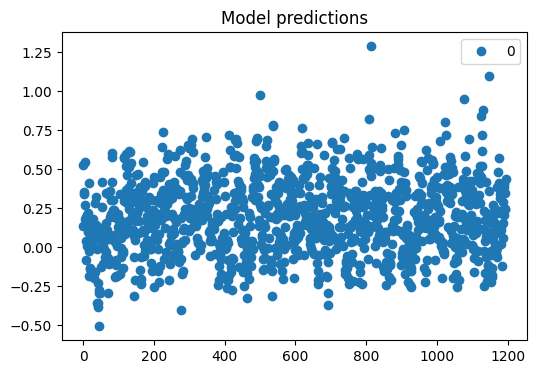

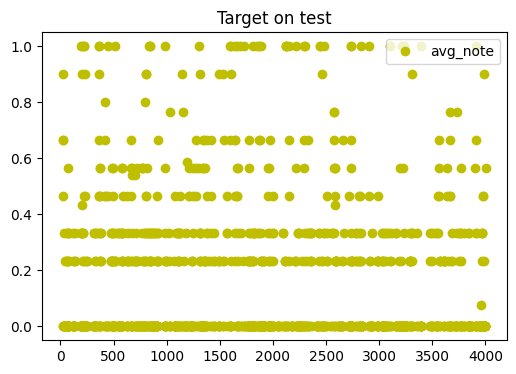

In [75]:
pd.DataFrame(y_pred_reg).plot(style='o', figsize=(6,4), title='Model predictions')
pd.DataFrame(target_test).plot(style='o',color='y', figsize=(6,4), title='Target on test')
plt.show()

Некоторые предсказания ниже нуля (настораживающее количество) или выше единицы (это скорее выбросы), основная масса ложится внутри необходимого диапазона [0, 1]. Тем не менее, есть ощущение, что модель плохо предсказывает высокое значение целевой переменной. Впрочем, на чем учили, то и получили: ведь в тренировочном датасете действительно мало высоких оценок...

**Catboost**

In [76]:
cb = catboost.CatBoostRegressor(iterations=1000,
                                verbose=100,
                                task_type='GPU',
                                eval_metric='RMSE',
                                random_seed=6767)
train_pool = catboost.Pool(features_train, target_train)
val_pool = catboost.Pool(features_test, target_test)


In [77]:

cb.fit(train_pool,
       eval_set=val_pool,
       early_stopping_rounds=150)


Learning rate set to 0.069423
0:	learn: 0.2843769	test: 0.2602507	best: 0.2602507 (0)	total: 105ms	remaining: 1m 44s
100:	learn: 0.2292784	test: 0.2371902	best: 0.2371902 (100)	total: 4.59s	remaining: 40.9s
200:	learn: 0.2061430	test: 0.2336018	best: 0.2336018 (200)	total: 7.71s	remaining: 30.6s
300:	learn: 0.1923679	test: 0.2317353	best: 0.2316957 (299)	total: 10.8s	remaining: 25s
400:	learn: 0.1820837	test: 0.2307559	best: 0.2307103 (398)	total: 15s	remaining: 22.4s
500:	learn: 0.1737163	test: 0.2305001	best: 0.2302877 (473)	total: 18s	remaining: 17.9s
600:	learn: 0.1667170	test: 0.2299924	best: 0.2298152 (590)	total: 21s	remaining: 13.9s
700:	learn: 0.1616188	test: 0.2295535	best: 0.2295147 (685)	total: 23.9s	remaining: 10.2s
800:	learn: 0.1567055	test: 0.2291675	best: 0.2290908 (790)	total: 28.2s	remaining: 7s
900:	learn: 0.1523573	test: 0.2287841	best: 0.2286865 (874)	total: 31.2s	remaining: 3.42s
999:	learn: 0.1487071	test: 0.2287040	best: 0.2286011 (950)	total: 34.1s	remaining: 

Лучшее значение катбуста на тестовой выборке = 0.229. Это лучше, чем у регрессий. Попробуем в тестировании эту модель.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [78]:
#создаем вектор изображений
image_vectors = []
test_queries['image'].progress_apply(lambda x: image_vect(x, PATH_TEST))
outputs_tensor_test = torch.stack(image_vectors)

100%|██████████| 500/500 [00:32<00:00, 15.48it/s]


In [79]:
outputs_tensor_test.shape

torch.Size([500, 512])

In [80]:
df_test_images = pd.read_csv(os.path.join(PATH, 'test_images.csv'))

Пишем функцию для тестирования работы модели — выдачи изображения по запросу.

In [81]:
def testing(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in stop_kids:
            return print('WARNING: This image is unavailable in your country in compliance with local laws.')
    Xids_test = count_tf_idf.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(outputs_tensor_test)):

        features_test = pd.DataFrame(outputs_tensor_test[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))

        features_test.columns = features_test.columns.astype(str)
        target_pred_test = cb.predict(features_test.to_numpy())
        pred_list.append(target_pred_test[0])

        if target_pred_test > best:
            best = target_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread(os.path.join(PATH, 'test_images/') + test_queries.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

Делаем случайную выборку запросов, которые «скормим» функции.

In [82]:
queries_for_test = test_queries['query_text'].sample(10, random_state=123)
queries_for_test

229    The man is dressed in black and smiling while ...
337                            A man on an orange bike .
327    A tennis player in a blue shirt celebrates his...
416    A red high speed racing boat skips across the ...
306    A snowboarder in a red jacket slides down a sn...
131    A large crowd of girls are all wearing green s...
5                        A baby girl playing at a park .
431    An Asian woman is taking a photograph outside ...
434    A woman wearing a red coat begins to take a pi...
134    Middle school aged kids are showing their scho...
Name: query_text, dtype: object

Описание: The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence .
Лучшая вероятность: [0.26905838]
Лучший индекс: 325
Лучшее изображение:


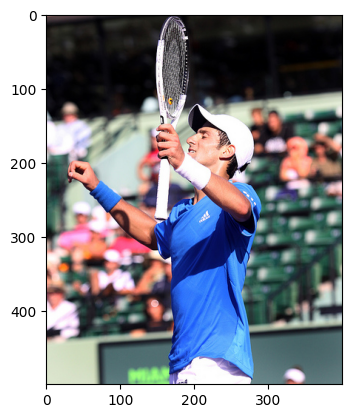

Описание: A man on an orange bike .
Лучшая вероятность: [0.26905838]
Лучший индекс: 325
Лучшее изображение:


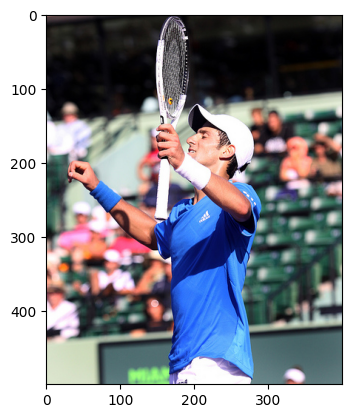

Описание: A tennis player in a blue shirt celebrates his match .
Лучшая вероятность: [0.26804956]
Лучший индекс: 10
Лучшее изображение:


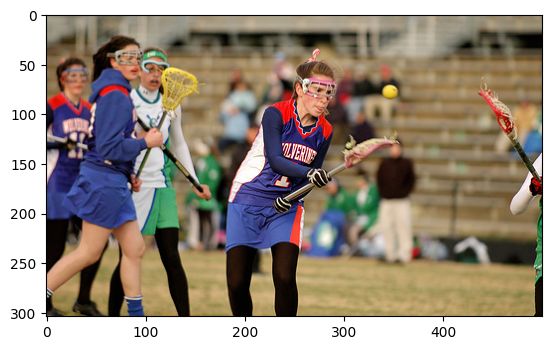

Описание: A red high speed racing boat skips across the water .
Лучшая вероятность: [0.26804956]
Лучший индекс: 10
Лучшее изображение:


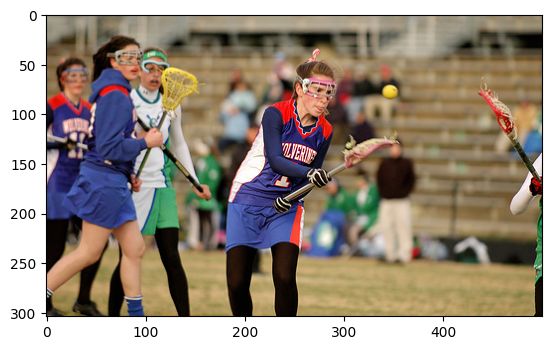

Описание: A snowboarder in a red jacket slides down a snowy mountain .
Лучшая вероятность: [0.26804956]
Лучший индекс: 10
Лучшее изображение:


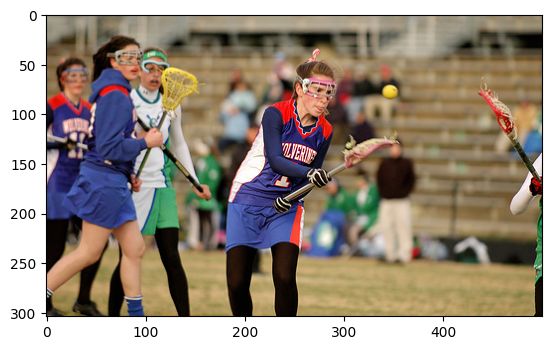

Описание: A large crowd of girls are all wearing green skirts and white tank tops .
Описание: A baby girl playing at a park .
Описание: An Asian woman is taking a photograph outside a white columned building .
Лучшая вероятность: [0.26804956]
Лучший индекс: 10
Лучшее изображение:


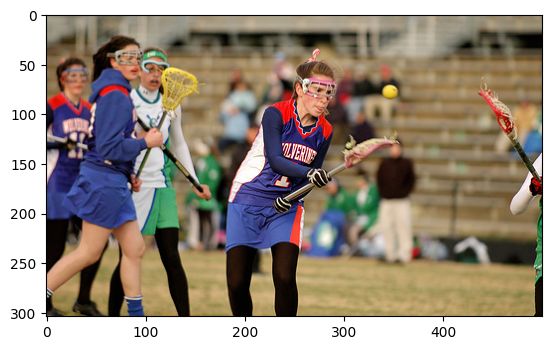

Описание: A woman wearing a red coat begins to take a picture .
Лучшая вероятность: [0.26804956]
Лучший индекс: 10
Лучшее изображение:


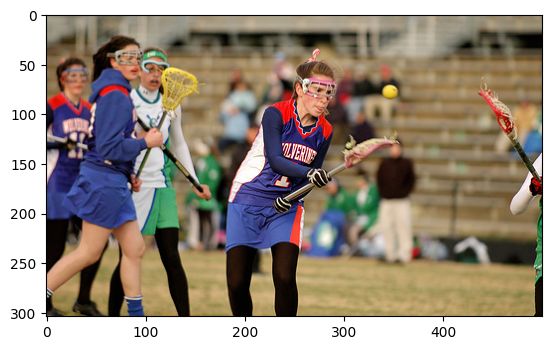

Описание: Middle school aged kids are showing their school spirit at a pep ralley .


In [83]:
for query in queries_for_test:
    testing(query)

Функция написана и со своей задачей справляется. Принимает на вход текст и находит изображение. Отрабатывают контроль "запрещенного контента".

К сожалению, работает она не очень. Основных причин на мой взгляд две:
    
 - низкое качество признаков
 - как следствие недоученные модели

Справедливости ради, модель признает, что оценка в районе 1 (из 4), то есть расписывается в своей некомпетентности подобрать изображение по запросу.

